In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Politician Trades/all_trades_cleaned_yahoo_prices.csv')
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df.sort_values('Transaction Date')
df

,Politician Name,Party,Chamber,State,Issuer Name,Ticker,Publication Date,Transaction Date,Reporting Gap,Owner,Transaction Type,Value Range,Price,Transaction ID,Approx Transaction Amount,Share Count
0,Tom Carper,Democrat,Senate,DE,Valero Energy Corp,VLO,2024-05-01,2024-04-11,19,Spouse,SELL,1K–15K,177.039993,10000062280,8000.0,45.0
1,Tom Carper,Democrat,Senate,DE,Enbridge Inc,ENB,2024-05-01,2024-04-11,19,Spouse,BUY,1K–15K,34.549999,10000062281,8000.0,231.0
2,Tom Carper,Democrat,Senate,DE,JPMorgan Chase & Co,JPM,2024-05-01,2024-04-01,29,Spouse,SELL,15K–50K,198.940002,10000062282,32500.0,163.0
3,Dan Newhouse,Republican,House,WA,Accenture PLC,ACN,2024-04-26,2024-04-10,15,Spouse,BUY,1K–15K,324.399994,20003772725,8000.0,24.0
4,Dan Newhouse,Republican,House,WA,Analog Devices Inc,ADI,2024-04-26,2024-04-10,15,Spouse,BUY,1K–15K,196.330002,20003772726,8000.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33333,Alan Lowenthal,Democrat,House,CA,Americold Realty Trust,COLD,2021-03-24,2021-03-15,8,Spouse,SELL,15K–50K,37.130001,20001621840,32500.0,875.0
33334,Mark Green,Republican,House,TN,NGL Energy Partners LP,NGL,2021-03-21,2021-03-17,3,Undisclosed,BUY,15K–50K,2.340000,20001620394,32500.0,13888.0
33335,Doug Lamborn,Republican,House,CO,NetApp Inc,NTAP,2021-03-20,2021-03-19,0,Spouse,SELL,15K–50K,70.160004,20001621844,32500.0,463.0
33336,Doug Lamborn,Republican,House,CO,NetApp Inc,NTAP,2021-03-20,2021-03-19,0,Undisclosed,SELL,1K–15K,70.160004,20001621847,8000.0,114.0


In [ ]:
sp500perf = (5018.39/3970.08-1)/1143*365
#Mar 15 2021 to May 1 2024
sp500perf

0.08432126329441163

In [ ]:
import pandas as pd
from datetime import datetime

def calculate_annualized_percentage_profit_with_ids(df):
    results = []
    # Group by Politician and Ticker
    grouped = df.groupby(['Politician Name', 'Ticker'])

    for (name, ticker), group in grouped:
        transactions = group.to_dict('records')

        # Initialize lists to track cycle details and amounts
        buy_prices = []
        sell_prices = []
        buy_ids = []
        sell_ids = []
        buy_amounts = []
        sell_amounts = []
        buy_dates = []
        sell_dates = []
        cycle_percentage_profits = []

        # Variable to track ongoing cycle
        is_cycle_active = False

        for transaction in transactions:
            date = pd.to_datetime(transaction['Transaction Date'])
            if transaction['Transaction Type'] == 'BUY':
                if is_cycle_active and sell_prices:  # If there were previous sales, close that cycle
                    # Calculate average dates and the days between them
                    avg_buy_date = pd.to_datetime(buy_dates).mean()
                    avg_sell_date = pd.to_datetime(sell_dates).mean()
                    days_between = (avg_sell_date - avg_buy_date).days

                    # Process the current cycle before starting a new buy
                    avg_buy_price = sum(buy_prices) / len(buy_prices)
                    avg_sell_price = sum(sell_prices) / len(sell_prices)
                    total_buy_amount = sum(buy_amounts)
                    total_sell_amount = sum(sell_amounts)
                    if avg_buy_price > 0 and days_between > 0:
                        percentage_profit = (avg_sell_price - avg_buy_price) / avg_buy_price * 100
                        annualized_profit = (percentage_profit / days_between) * 365
                        cycle_percentage_profits.append(annualized_profit)

                    # Record the cycle
                    results.append({
                        'Politician': name,
                        'Ticker': ticker,
                        'Annualized Percentage Profit': sum(cycle_percentage_profits) / len(cycle_percentage_profits) if cycle_percentage_profits else 0,
                        # 'Average Percentage Profit': percentage_profit,
                        # 'Days Between': days_between,
                        'Purchase Transaction IDs': buy_ids,
                        'Sell Transaction IDs': sell_ids,
                        'Total Purchase Amount': total_buy_amount,
                        'Total Sell Amount': total_sell_amount
                    })
                    # Reset for new cycle
                    buy_prices = []
                    sell_prices = []
                    buy_ids = []
                    sell_ids = []
                    buy_amounts = []
                    sell_amounts = []
                    buy_dates = []
                    sell_dates = []
                    cycle_percentage_profits = []
                    is_cycle_active = False

                # Start or continue a buy cycle
                buy_prices.append(transaction['Price'])
                buy_ids.append(transaction['Transaction ID'])
                buy_amounts.append(transaction['Approx Transaction Amount'])
                buy_dates.append(date)
                is_cycle_active = True

            elif transaction['Transaction Type'] == 'SELL' and buy_prices:
                sell_prices.append(transaction['Price'])
                sell_ids.append(transaction['Transaction ID'])
                sell_amounts.append(transaction['Approx Transaction Amount'])
                sell_dates.append(date)

        # Check if there's an ongoing cycle to process at the end of transactions
        if is_cycle_active and buy_prices and sell_prices:
            avg_buy_date = pd.to_datetime(buy_dates).mean()
            avg_sell_date = pd.to_datetime(sell_dates).mean()
            days_between = (avg_sell_date - avg_buy_date).days

            avg_buy_price = sum(buy_prices) / len(buy_prices)
            avg_sell_price = sum(sell_prices) / len(sell_prices)
            total_buy_amount = sum(buy_amounts)
            total_sell_amount = sum(sell_amounts)
            if avg_buy_price > 0 and days_between > 0:
                percentage_profit = (avg_sell_price - avg_buy_price) / avg_buy_price * 100
                annualized_profit = (percentage_profit / days_between) * 365
                cycle_percentage_profits.append(annualized_profit)

            # Record the last cycle
            results.append({
                'Politician': name,
                'Ticker': ticker,
                'Annualized Percentage Profit': sum(cycle_percentage_profits) / len(cycle_percentage_profits) if cycle_percentage_profits else 0,
                # 'Average Percentage Profit': percentage_profit,
                # 'Days Between': days_between,
                'Purchase Transaction IDs': buy_ids,
                'Sell Transaction IDs': sell_ids,
                'Total Purchase Amount': total_buy_amount,
                'Total Sell Amount': total_sell_amount
            })

    return pd.DataFrame(results)

# Sample usage with the DataFrame loaded
profits = calculate_annualized_percentage_profit_with_ids(df)

In [ ]:
def calculate_average_percentage_profit_with_ids():
    results = []
    # Group by Politician and Ticker
    grouped = df.groupby(['Politician Name', 'Ticker'])

    for (name, ticker), group in grouped:
        transactions = group.to_dict('records')

        # Initialize lists to track cycle details and amounts
        buy_prices = []
        sell_prices = []
        buy_ids = []
        sell_ids = []
        buy_amounts = []
        sell_amounts = []
        cycle_percentage_profits = []

        # Variable to track ongoing cycle
        is_cycle_active = False

        for transaction in transactions:
            if transaction['Transaction Type'] == 'BUY':
                if is_cycle_active and sell_prices:  # If there were previous sales, close that cycle
                    # Process the current cycle before starting a new buy
                    avg_buy_price = sum(buy_prices) / len(buy_prices)
                    avg_sell_price = sum(sell_prices) / len(sell_prices)
                    total_buy_amount = sum(buy_amounts)
                    total_sell_amount = sum(sell_amounts)
                    if avg_buy_price > 0:
                        percentage_profit = (avg_sell_price - avg_buy_price) / avg_buy_price * 100
                        cycle_percentage_profits.append(percentage_profit)
                    # Record the cycle
                    results.append({
                        'Politician': name,
                        'Ticker': ticker,
                        'Average Percentage Profit': sum(cycle_percentage_profits) / len(cycle_percentage_profits) if cycle_percentage_profits else 0,
                        'Purchase Transaction IDs': buy_ids,
                        'Sell Transaction IDs': sell_ids,
                        'Total Purchase Amount': total_buy_amount,
                        'Total Sell Amount': total_sell_amount
                    })
                    # Reset for new cycle
                    buy_prices = []
                    sell_prices = []
                    buy_ids = []
                    sell_ids = []
                    buy_amounts = []
                    sell_amounts = []
                    cycle_percentage_profits = []
                    is_cycle_active = False

                # Start or continue a buy cycle
                buy_prices.append(transaction['Price'])
                buy_ids.append(transaction['Transaction ID'])
                buy_amounts.append(transaction['Approx Transaction Amount'])
                is_cycle_active = True

            elif transaction['Transaction Type'] == 'SELL' and buy_prices:
                sell_prices.append(transaction['Price'])
                sell_ids.append(transaction['Transaction ID'])
                sell_amounts.append(transaction['Approx Transaction Amount'])

        # Check if there's an ongoing cycle to process at the end of transactions
        if is_cycle_active and buy_prices and sell_prices:
            avg_buy_price = sum(buy_prices) / len(buy_prices)
            avg_sell_price = sum(sell_prices) / len(sell_prices)
            total_buy_amount = sum(buy_amounts)
            total_sell_amount = sum(sell_amounts)
            if avg_buy_price > 0:
                percentage_profit = (avg_sell_price - avg_buy_price) / avg_buy_price * 100
                cycle_percentage_profits.append(percentage_profit)
            # Record the last cycle
            results.append({
                'Politician': name,
                'Ticker': ticker,
                'Average Percentage Profit': sum(cycle_percentage_profits) / len(cycle_percentage_profits) if cycle_percentage_profits else 0,
                'Purchase Transaction IDs': buy_ids,
                'Sell Transaction IDs': sell_ids,
                'Total Purchase Amount': total_buy_amount,
                'Total Sell Amount': total_sell_amount
            })

    return pd.DataFrame(results)

# Sample usage with the DataFrame loaded
profits = calculate_average_percentage_profit_with_ids()

In [ ]:
# V2
import pandas as pd

def calculate_annualized_percentage_profit_with_ids(df):
    results = []
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

    # Group by Politician and Ticker
    grouped = df.groupby(['Politician Name', 'Ticker'])

    for (name, ticker), group in grouped:
        transactions = group.sort_values('Transaction Date').to_dict('records')

        # Initialize lists to track cycle details and amounts
        buy_prices = []
        sell_prices = []
        buy_ids = []
        sell_ids = []
        buy_amounts = []
        sell_amounts = []
        buy_dates = []
        sell_dates = []
        buying = True  # Assume we start with buying

        for transaction in transactions:
            date = transaction['Transaction Date']
            if buying and transaction['Transaction Type'] == 'BUY':
                # Continue adding to the current buy cycle
                buy_prices.append(transaction['Price'])
                buy_ids.append(transaction['Transaction ID'])
                buy_amounts.append(transaction['Approx Transaction Amount'])
                buy_dates.append(date)
            elif buying and transaction['Transaction Type'] == 'SELL':
                # Transition from buying to selling
                buying = False
                sell_prices.append(transaction['Price'])
                sell_ids.append(transaction['Transaction ID'])
                sell_amounts.append(transaction['Approx Transaction Amount'])
                sell_dates.append(date)
            elif not buying and transaction['Transaction Type'] == 'SELL':
                # Continue adding to the current sell cycle
                sell_prices.append(transaction['Price'])
                sell_ids.append(transaction['Transaction ID'])
                sell_amounts.append(transaction['Approx Transaction Amount'])
                sell_dates.append(date)
            elif not buying and transaction['Transaction Type'] == 'BUY':
                # Process the previous sell cycle before starting a new buy cycle
                if buy_prices and sell_prices:
                    cycle_results = process_cycle(name, ticker, buy_prices, sell_prices, buy_ids, sell_ids, buy_amounts, sell_amounts, buy_dates, sell_dates)
                    results.extend(cycle_results)

                # Reset the lists for a new buy cycle
                buy_prices, sell_prices, buy_ids, sell_ids, buy_amounts, sell_amounts, buy_dates, sell_dates = [], [], [], [], [], [], [], []
                # Start a new buy cycle
                buying = True
                buy_prices.append(transaction['Price'])
                buy_ids.append(transaction['Transaction ID'])
                buy_amounts.append(transaction['Approx Transaction Amount'])
                buy_dates.append(date)

        # Process any remaining buy-sell cycle
        if buy_prices and sell_prices:
            cycle_results = process_cycle(name, ticker, buy_prices, sell_prices, buy_ids, sell_ids, buy_amounts, sell_amounts, buy_dates, sell_dates)
            results.extend(cycle_results)

    return pd.DataFrame(results)

def process_cycle(name, ticker, buy_prices, sell_prices, buy_ids, sell_ids, buy_amounts, sell_amounts, buy_dates, sell_dates):
    if not buy_dates or not sell_dates:
        return []  # Avoid processing if there are no valid buy or sell dates

    first_buy_date = min(buy_dates) if buy_dates else None
    last_sell_date = max(sell_dates) if sell_dates else None
    days_between = (last_sell_date - first_buy_date).days if first_buy_date and last_sell_date else 0

    if days_between > 0 and buy_prices and sell_prices:
        avg_buy_price = sum(buy_prices) / len(buy_prices)
        avg_sell_price = sum(sell_prices) / len(sell_prices)
        percentage_profit = (avg_sell_price - avg_buy_price) / avg_buy_price * 100
        annualized_profit = (percentage_profit / days_between) * 365
        return [{
            'Politician': name,
            'Ticker': ticker,
            'Annualized Percentage Profit': annualized_profit,
            'Purchase Transaction IDs': buy_ids,
            'Sell Transaction IDs': sell_ids,
            'Total Purchase Amount': sum(buy_amounts),
            'Total Sell Amount': sum(sell_amounts)
        }]
    return []

# Sample usage with the DataFrame loaded
profits = calculate_annualized_percentage_profit_with_ids(df)

In [ ]:
profits['Annualized Percentage Profit'].mean()

-9.764128626623554

In [ ]:
profits.sort_values('Annualized Percentage Profit')

,Politician,Ticker,Annualized Percentage Profit,Purchase Transaction IDs,Sell Transaction IDs,Total Purchase Amount,Total Sell Amount
4006,Ro Khanna,OKTA,-2863.003057,[20003741973],[20003741427],8000.0,8000.0
3855,Ro Khanna,MTCH,-2354.066985,[20003757234],[20003757516],8000.0,32500.0
5237,Tom Suozzi,UPST,-1909.892368,"[20003723764, 20003723765]","[20003723763, 20003723766]",65000.0,16000.0
3573,Ro Khanna,LULU,-1247.404265,[20003772192],[20003772110],8000.0,8000.0
4981,Ro Khanna,ZM,-1095.760885,[20003684224],[20003684253],8000.0,8000.0
...,...,...,...,...,...,...,...
5381,Tommy Tuberville,PYPL,1630.887975,[10000060480],"[10000060485, 10000060484, 10000060483, 100000...",175000.0,266000.0
739,Jim Banks,RBLX,1960.844078,[20003708653],"[20003708651, 20003708654]",32500.0,40500.0
5285,Tommy Tuberville,CLF,2365.535331,[10000061256],[10000061243],75000.0,8000.0
1447,Marie Newman,PTON,3161.461424,[20003694412],[20003694413],8000.0,8000.0


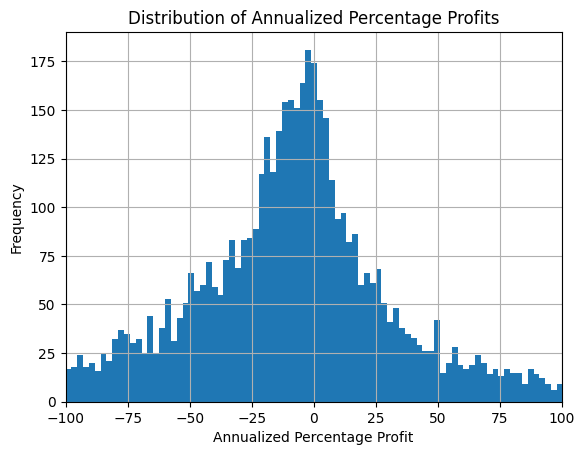

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'profits' is your DataFrame and it has been loaded and processed appropriately
profits = calculate_annualized_percentage_profit_with_ids(df)  # Example function call

# Create a histogram of the 'Annualized Percentage Profit'
ax = profits['Annualized Percentage Profit'].hist(bins=3000)

# Set x-axis range from -100 to 100
ax.set_xlim(-100, 100)

# Optionally, add labels and a title
ax.set_xlabel('Annualized Percentage Profit')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Annualized Percentage Profits')

# Show the plot
plt.show()

In [ ]:
profits[(profits.Politician =='Josh Gottheimer') & (profits.Ticker == 'MDB')]

,Politician,Ticker,Annualized Percentage Profit,Purchase Transaction IDs,Sell Transaction IDs,Total Purchase Amount,Total Sell Amount
1013,Josh Gottheimer,MDB,-76.795782,[20003697543],[20003720226],8000.0,8000.0
1014,Josh Gottheimer,MDB,-107.455470,[20003723659],[20003755432],8000.0,8000.0
1015,Josh Gottheimer,MDB,57.436788,"[20003755685, 20003761192]","[20003763799, 20003771278]",16000.0,16000.0


<Axes: >

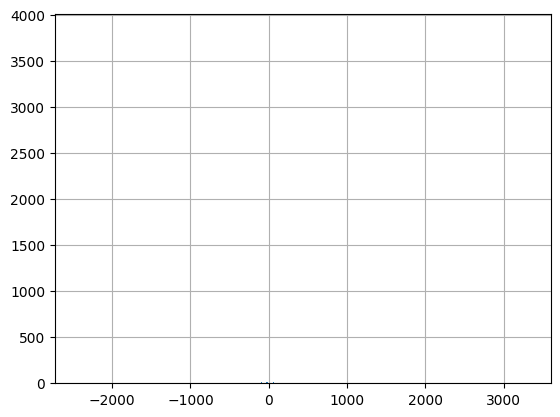

In [ ]:
profits['Annualized Percentage Profit'].hist(bins=1000)

In [ ]:
profits.groupby('Politician')['Average Percentage Profit'].mean().reset_index().sort_values(by='Average Percentage Profit',ascending=False)

,Politician,Average Percentage Profit
39,Neal Dunn,56.250482
7,Dan Crenshaw,41.999136
2,Austin Scott,23.001185
8,Dan Newhouse,22.550534
21,Jim Langevin,15.620416
19,Hal Rogers,15.399734
23,John Curtis,14.432646
51,Tomasz Malinowski,11.610875
36,Mike Garcia,8.946876
16,Ed Perlmutter,8.910744


In [ ]:
profits[profits.Politician == 'Nancy Pelosi']

,Politician,Ticker,Average Percentage Profit,Purchase Transaction IDs,Sell Transaction IDs,Total Purchase Amount,Total Sell Amount
1147,Nancy Pelosi,AAPL,-22.840973,"[20003764520, 20003761537]",[20003750401],1125000.0,175000.0
1148,Nancy Pelosi,NVDA,-69.485385,[20003770148],"[20003755449, 20003750755]",3000000.0,3175000.0


In [ ]:
df['Transaction Date'].min()

Timestamp('2021-03-14 00:00:00')

In [ ]:
file_path = '/content/drive/MyDrive/Politician Trades/combined_trades.csv'

# Save to CSV
profits.to_csv(file_path, index=False)

In [ ]:
profits['Last Sale ID'] = profits['Sell Transaction IDs'].apply(lambda x: x[-1] if x else None)
profits_merged = profits.merge(df[['Transaction ID', 'Reporting Gap']], left_on='Last Sale ID', right_on='Transaction ID')
profits_merged = profits_merged[profits_merged['Reporting Gap'] < 100]


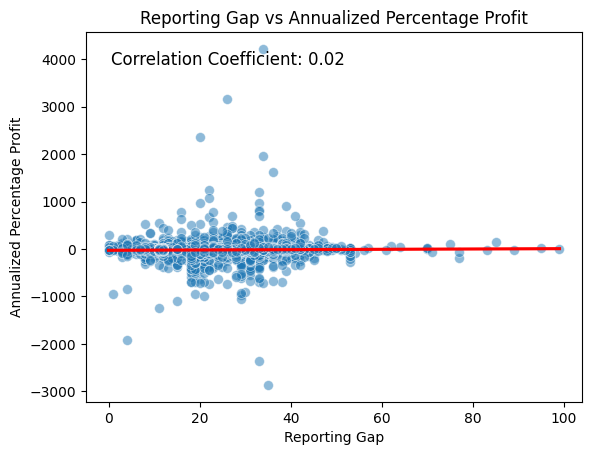

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'profits' is your DataFrame containing the data
# Calculate the Pearson correlation coefficient
correlation = profits_merged['Reporting Gap'].corr(profits['Annualized Percentage Profit'])

# Create the scatter plot with adjusted marker size and alpha
sns.scatterplot(data=profits_merged, x='Reporting Gap', y='Annualized Percentage Profit', s=50, alpha=0.5)

# Add regression line
sns.regplot(data=profits_merged, x='Reporting Gap', y='Annualized Percentage Profit', scatter=False, color='red')

# Set the title and labels
plt.title('Reporting Gap vs Annualized Percentage Profit')
plt.xlabel('Reporting Gap')
plt.ylabel('Annualized Percentage Profit')

# Display the correlation coefficient on the plot
plt.text(0.05, 0.95, f'Correlation Coefficient: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Show the plot
plt.show()


In [ ]:
file_path = '/content/drive/MyDrive/Politician Trades/profit_report_corr.csv'

# Save to CSV
profits_merged.to_csv(file_path, index=False)